# Price Trajectories for Cryptos

In [9]:
#Libraries
import pandas as pd
import numpy as np
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.optimize import Bounds
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
from arch.univariate import EWMAVariance,ZeroMean

In [10]:
#Load daily historical series
btc_d = pd.read_excel('DAI.xlsx', sep=',',index_col=[0], parse_dates=True)

In [11]:
btc_d.describe()

,Close,High,Low,Open,VolumeFrom,VolumeTo
count,1175.000000,1175.000000,1175.000000,1175.000000,1.175000e+03,1.175000e+03
mean,1.004571,1.025721,0.983210,1.005390,1.764155e+06,1.772356e+06
std,0.019468,0.035820,0.033883,0.029391,5.146612e+06,5.167196e+06
min,0.819200,0.970400,0.741400,0.952800,0.000000e+00,0.000000e+00
25%,0.998800,1.005000,0.970800,0.998800,1.278387e+05,1.279170e+05
50%,1.002000,1.015000,0.991000,1.002000,3.938842e+05,3.930110e+05
75%,1.008000,1.031000,1.000000,1.008000,1.143856e+06,1.152645e+06
max,1.256000,1.317000,1.150000,1.753000,8.825870e+07,8.898492e+07


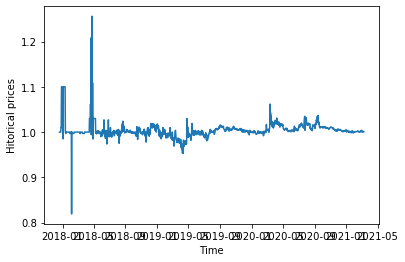

In [12]:
plt.plot(btc_d.index, btc_d.Close)
plt.xlabel('Time')
plt.ylabel('Hitorical prices')
plt.show()

## Estimate parameter of Ornstein-Uhlenbeck/Vasicek Model for historical data
Let $dX_{t}=(\theta_{1}-\theta_{2}X_{t})dt+\theta_{3}dW_{t}$, $X_{0}=x_{0}>0$, guess solution $x\exp^{\theta_{2}t}$ $\Rightarrow$ by Ito
\begin{align*}
d(X_{t}\exp^{\theta_{2}t})&=& \theta_{2}\exp^{\theta_{2}t} X_{t}dt + \exp^{\theta_{2}t}dX_{t}\\
&=& \exp^{\theta_{2}t} (\theta_{1}dt + \theta_{3}dW_{t})
\end{align*}
\begin{align*}
X_{t}\exp^{\theta_{2}t}&=&x_{0}+\theta_{1}\int_{0}^{t}\exp^{\theta_{2}s}ds+\int_{0}^{t}\theta_{3} \exp^{\theta_{2}s} dW_{s}\\
X_{t}\exp^{\theta_{2}t}&=&x_{0}+\frac{\theta_{1}}{\theta_{2}}(\exp^{\theta_{2}t}-1)++\int_{0}^{t}\theta_{3} \exp^{\theta_{2}s} dW_{s}
\end{align*}
\begin{align*}
X_{t}&=&\frac{\theta_{1}}{\theta_{2}}+(x_{0}-\frac{\theta_{1}}{\theta_{2}})\exp^{-\theta_{2}t}+\theta_{3}\int_{0}^{t}\exp^{-\theta_{2}(t-s)}dW_{s}\\
X_{t} &\sim& N(\frac{\theta_{1}}{\theta_{2}}+(x_{0}-\frac{\theta_{1}}{\theta_{2}})\exp^{-\theta_{2}t}, \frac{\theta_{3}^{2}(1- \exp^{-2\theta_{2}t})}{2\theta_{2}})
\end{align*}
Normal distribution
\begin{align*}
p(t,y \mid x_{0}; \mathbf{\theta})&=&\frac{1}{v \sqrt{2 \pi}}\exp(-\frac{(y-m)^{2}}{2v^{2}})
\end{align*}
Find $\mathbf{\theta}$ numerically.

In [13]:
def neg_log_like_OU(y,theta):
    dt = 0.01
    x0 = y[:-1]
    ml= (theta[0]/theta[1])+(x0-(theta[0]/theta[1]))*np.exp(-theta[1]*dt)
    sl= ((theta[2]**2)*(1-np.exp(-2*theta[1]*dt)))/(2*theta[1])
    loglike= np.sum(norm.pdf(y[1:], loc=ml,scale=np.sqrt(sl)))
    return -loglike

In [15]:
neg_log_like_OU(btc_d.Close,(0.5,0.5,0.5))

-9219.03278377172

In [16]:
objective = partial(neg_log_like_OU, btc_d.Close)
bounds = Bounds([-10.0, 0.01, 0.01], [10.0, 2.0, 10.0])

In [17]:
# Actually do the minimization
result = scipy.optimize.minimize(objective, (1,0.5,1), method='trust-constr', bounds=bounds)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

C:\nconda\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


theta MLE: [0.00492853 0.01438294 0.01      ]


## Simulate Ornstein-Uhlenbeck
From the SDE of the process
\begin{equation*}
dX_{t}=(\theta_{1}-\theta_{2}X_{t})dt+\theta_{3}dW_{t}
\end{equation*}
We can obtain an Euler (discrete) approximation 
the we can simulate teh values of $X_{t}$ for $t=1,\ldots,T$
\begin{equation*}
X_{t+1}= X_{t} + (\theta_{1}-\theta_{2}X_{t})(t+1-t)+\theta_{3}\sqrt{t+1-t} Z_{t+1}
\end{equation*}
where $Z_{1},\ldots,Z_{T}$ are independent standard normals. To be consistent with the mean reversion of the process we suggest to set $\theta_{1}=\theta_{2}$ so the long term value is equal to $1.0$ which is the case of Stablecoins.

In [18]:
def sim_OU(S0,Llev,mu,sigma,dt,T):
    Z=np.random.normal(loc=0.0, scale=1, size=T)
    y = np.ndarray(T)
    y[0]=S0
    for t in range(1, T):
        y[t] = y[t-1]+(Llev-mu*y[t-1])*dt+sigma*np.sqrt(dt)*Z[t]
    return y

In [19]:
path1=sim_OU(1,theta_mle[0],theta_mle[1],theta_mle[2],0.01,100)

In [20]:
path1

array([1.        , 0.9980882 , 0.99754097, 0.99626722, 0.99493007,
       0.99574841, 0.99468324, 0.99417354, 0.99499663, 0.9937744 ,
       0.99384282, 0.99483569, 0.99468976, 0.99389062, 0.99480817,
       0.99524606, 0.99594471, 0.99581578, 0.99533232, 0.99458532,
       0.99310001, 0.99222158, 0.99252433, 0.99255139, 0.99219035,
       0.99248226, 0.99104376, 0.99033694, 0.98941795, 0.9882953 ,
       0.98782128, 0.98716806, 0.98735359, 0.98778508, 0.988765  ,
       0.98910219, 0.98928024, 0.98880164, 0.98837605, 0.98737261,
       0.9883704 , 0.98765652, 0.98910305, 0.98806395, 0.9866203 ,
       0.98733959, 0.9876843 , 0.98696488, 0.98527239, 0.98482513,
       0.98677579, 0.98660536, 0.98668462, 0.98849912, 0.98961169,
       0.99053679, 0.9921134 , 0.99107572, 0.99054379, 0.98952219,
       0.98982135, 0.98989387, 0.98895413, 0.98832638, 0.98642899,
       0.98408847, 0.98438318, 0.98344137, 0.981567  , 0.98243993,
       0.98197178, 0.98224533, 0.9798713 , 0.97877728, 0.97920

In [46]:
path2=sim_OU(1,0.5,0.5,0.05,0.01,100)

In [47]:
path2

array([1.        , 1.00274904, 1.01117825, 1.01348879, 1.01177633,
       1.01038738, 1.01215481, 1.02113045, 1.02699888, 1.02800152,
       1.02810447, 1.01973139, 1.02720173, 1.0346931 , 1.0299921 ,
       1.02805002, 1.03023252, 1.02832356, 1.02437246, 1.01936252,
       1.02586256, 1.02207088, 1.01584277, 1.0286561 , 1.03058334,
       1.03132578, 1.030692  , 1.02130644, 1.02304381, 1.0221562 ,
       1.02166953, 1.02245978, 1.02387522, 1.0172362 , 1.02135977,
       1.02228023, 1.02665631, 1.02822608, 1.01832494, 1.01603269,
       1.01342662, 1.01473402, 1.01720264, 1.0238247 , 1.02274323,
       1.02295704, 1.02355274, 1.0185767 , 1.02402038, 1.03103295,
       1.02713525, 1.0283874 , 1.02410552, 1.02861939, 1.03245777,
       1.03531737, 1.03207523, 1.0303471 , 1.03860431, 1.03600767,
       1.03532312, 1.03390451, 1.02711698, 1.03163984, 1.03104147,
       1.02564044, 1.02774131, 1.02272335, 1.02370963, 1.01299876,
       1.01684465, 1.02235666, 1.02188395, 1.01774971, 1.02317

In [21]:
Nsim=120
paths=pd.DataFrame(columns=range(Nsim))
for i in range(Nsim):
    paths.iloc[:,i]=sim_OU(1,theta_mle[0],theta_mle[1],theta_mle[2],0.01,100)
    #paths.iloc[:,i]=sim_OU(1,0.5,0.5,0.05,0.01,100)

In [22]:
paths.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001039,1.000136,0.999456,0.999378,0.999304,1.001005,0.999189,1.000019,0.999217,1.000271,...,1.002587,1.000778,1.000242,0.998833,0.999695,0.999698,0.998620,0.999210,0.999290,0.997713
2,1.000395,1.000683,1.001507,0.998664,0.999044,1.001037,0.998744,1.000255,1.000986,0.998867,...,1.003374,0.999518,1.001151,1.001125,1.000871,0.999760,0.998750,0.997409,0.999928,0.998257
3,0.999250,0.999344,1.003515,0.999855,0.999212,1.000151,0.998245,1.001007,1.000937,0.998274,...,1.004168,0.999054,1.002061,1.001477,1.000052,0.997939,0.998305,0.998138,1.001140,0.998074
4,0.999723,0.998805,1.004923,0.999974,0.997751,1.001647,0.995776,1.000919,1.001218,0.998719,...,1.002811,0.999555,1.001905,1.002145,0.999327,0.997991,0.998172,0.998625,1.001426,0.995724


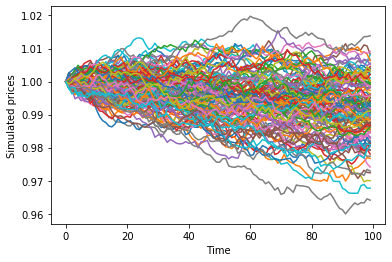

In [23]:
#simulated prices
plt.plot(range(100), paths)
plt.xlabel('Time')
plt.ylabel('Simulated prices')
plt.show()

## Time varying Volatility GARCH(1,1) where EWMA is a particular case

Let $\lambda \in (0,1)$ denote the strenght of autocorrelation in volatility process.
\begin{equation*}
\sigma_{t}^{2} =\lambda\sigma_{t-1}^{2}+(1-\lambda)r_{t-1}^{2}
\end{equation*}
Volatility estimate for day $t$ is given by: the previous estimate $\sigma_{t-1}$ and most recent change in the return process $r_{t-1}$.

In [24]:
#Log Returns
ret=np.log(btc_d.Close).diff(periods=1)*100
ret=ret[1:]

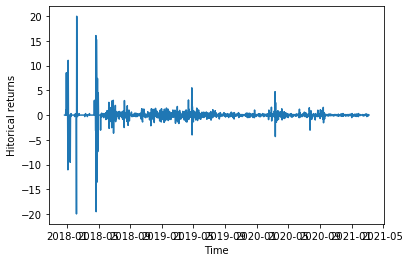

In [25]:
plt.plot(btc_d.index[1:], ret)
plt.xlabel('Time')
plt.ylabel('Hitorical returns')
plt.show()

In [26]:
ret0=ZeroMean(ret)
ret0.volatility=EWMAVariance(lam=0.95)
ewma=ret0.fit()

In [27]:
daily_std=np.sqrt(ewma.conditional_volatility/100)#*np.sqrt(252) #yealy

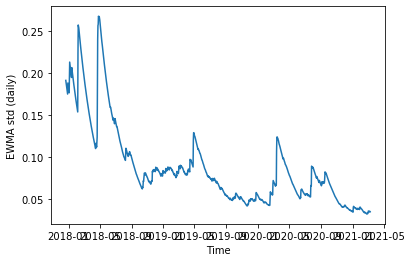

In [28]:
plt.plot(daily_std.index, daily_std)
plt.xlabel('Time')
plt.ylabel('EWMA std (daily)')
plt.show()

In [29]:
daily_std.describe()

count    1174.000000
mean        0.088810
std         0.049427
min         0.032832
25%         0.053473
50%         0.076823
75%         0.101845
max         0.267757
Name: cond_vol, dtype: float64